In [1]:
import os
import pandas as pd
import os.path as osp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load files

In [2]:
os.getcwd()

'D:\\Project- Electro\\social_behavior_electro\\data_organization\\python'

In [3]:
folder_path = osp.join('..','..','analysis')
path_to_aversive_enc_pre = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_aversive.xlsx')
path_to_affiliative_enc_pre = osp.join(folder_path,
                               'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_affiliative.xlsx')

path_to_aversive_post_pre = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - PostEncounter-PreEncounter_4-12_30-80_aversive.xlsx')
path_to_affiliative_post_pre = osp.join(folder_path,
                               'Population analysis results for LFP Coherence - PostEncounter-PreEncounter_4-12_30-80_affiliative.xlsx')



path_to_affiliative_lfp = osp.join(folder_path,
                            'lfp_rawdata_affiliative.xlsx') 

path_to_aversive_lfp = osp.join(folder_path,
                            'lfp_rawdata_aversive.xlsx')

path_to_common_areas = osp.join(folder_path, 'common_area_pairs_w5_sessions.xlsx')



In [4]:
df_aff_lfp_raw = pd.read_excel(path_to_affiliative_lfp ,header=[0,1,2], index_col=[0])
df_avv_lfp_raw = pd.read_excel(path_to_aversive_lfp ,header=[0,1,2], index_col=[0])

In [5]:
df_aff_enc_pre = pd.read_excel(path_to_affiliative_enc_pre,None)
df_avv_enc_pre = pd.read_excel(path_to_aversive_enc_pre,None)

df_aff_post_pre = pd.read_excel(path_to_affiliative_post_pre,None)
df_avv_post_pre = pd.read_excel(path_to_aversive_post_pre,None)


df_files_avv_bad = pd.read_excel(path_to_aversive_enc_pre,'Uploaded files', header=None)
df_files_aff_bad = pd.read_excel(path_to_affiliative_enc_pre,'Uploaded files', header=None)

df_areas = pd.read_excel(path_to_common_areas)


## Clean and combine data

In [6]:
import re

def fix_file_paths(df_files):
    
    df_files = df_files.rename(columns={df_files.columns[0]:'timestamps', df_files.columns[0]:'lfp', })
    
    return df_files
df_files_avv = fix_file_paths(df_files_avv_bad)['lfp']
df_files_aff = fix_file_paths(df_files_aff_bad)['lfp']


def extract_ratnum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"rat(\d{1,2})", filename.lower())

    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number

def extract_daynum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"day(\d{1,2})", filename.lower())
    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number
# rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]


In [7]:
area_num_to_name_map = {
    '111': 'MeD',
    '2': 'MePV',
    '13':'CeA',
    '112': 'BMA',
    '14': 'AA',
    '16': 'EA',
    '12': 'STIA',
    '15': 'VP'
}



def reformat_columns(df):
    # combine column names and remove levels
    df_new = pd.DataFrame()
    areas = df.columns.get_level_values('area').unique()
    freqs = df.columns.get_level_values('freq').unique()
    stages = df.columns.get_level_values('stage').unique()

    df_new.index = df.index
    for area in areas:
        for freq in freqs:
            for stage in stages:

                col_name = (area, freq, stage)
                
                area_name = area_num_to_name_map[area]
                if "diffduring" in stage.lower():
                    new_stage = 'enc_pre'
                elif"diffafter" in stage.lower():
                    new_stage = 'post_pre'
                else:
                    continue
                
                new_freq = freq.replace('-','_') + 'Hz'
                
                
                new_col_name = '_'.join((area_name, new_freq, new_stage))

                df_new[new_col_name] = df[col_name]
    return df_new

In [8]:
df_aff_lfp = reformat_columns(df_aff_lfp_raw)

df_avv_lfp = reformat_columns(df_avv_lfp_raw)


In [9]:
# Add variables befor concatination
df_aff_enc_pre = pd.read_excel(path_to_affiliative_enc_pre,None)
# df_aff_enc_pre['sociability'] = 'affiliative'
# df_aff_enc_pre['stage'] = 'enc_pre'

df_aff_post_pre = pd.read_excel(path_to_affiliative_post_pre,None)
# df_aff_post_pre['sociability'] = 'affiliative'
# df_aff_post_pre['stage'] = 'post_pre'


df_avv_enc_pre = pd.read_excel(path_to_aversive_enc_pre,None)
# df_avv_enc_pre['sociability'] = 'aversive'
# df_avv_enc_pre['stage'] = 'enc_pre'


df_avv_post_pre = pd.read_excel(path_to_aversive_post_pre,None)
# df_avv_post_pre['sociability'] = 'aversive'
# df_avv_post_pre['stage'] = 'post_pre'



In [10]:
freq_keywords = {'First': '4_18Hz', 'Second':'30_80Hz'}
stage_keywords = {'During':'enc_pre', 'After':'post_pre'}
substrings_to_remove = ['During', 'After','Before', 'First', 'Second']
ignore_keyworks = ['Norm', 'files']

def remove_columns_with_fewer_values(df, N=5):
    # Get the count of non-null values in each column
    column_counts = df.count()

    # Filter columns based on count condition
    columns_to_remove = column_counts[column_counts < N].index

    # Drop the columns from the DataFrame
    updated_df = df.drop(columns=columns_to_remove)

    return updated_df

def reformat_dict_to_table(df_dict, file_df):
# def reformat_dict_to_table(df_dict, freq_keywords, stage_keywords, ignore_keyworks, substrings_to_remove):
    ret_df_list = []
    for sheet, df in df_dict.items():
        df = df.copy()
        # ignore first and last sheets that contain a summary and list of file names
        if any(substring in sheet for substring in ignore_keyworks): 
            continue
            
        if isinstance(df, str):
            print(df)
            continue
            
        if len(df) == 0:
            continue
        
         # Remove all substrings to keep just the area name
        area_name = sheet
        for sub_string_to_remove in substrings_to_remove:
            area_name = area_name.replace(sub_string_to_remove,'')
        
        for fk, freq in  freq_keywords.items():
            if fk in sheet:
                this_freq = freq_keywords[fk]
            for sk in stage_keywords.keys():
                if sk in sheet:
                    this_stage = stage_keywords[sk]
        
                # Rename all column names to match
        
        for col in df.columns:
            area_pair = [col, area_name]
            area_pair.sort()
            
            df.rename(columns={col:f'{area_pair[0]}_{area_pair[1]}_{this_freq}_{this_stage}'}, inplace=True)
        
        
        df.dropna(axis=1, how='all', inplace=True)
        df = remove_columns_with_fewer_values(df)
        ret_df_list.append(df)
        
    df_ret = pd.concat(ret_df_list,axis=1)
    df_ret['files'] = file_df.values
    return df_ret
                
            



In [11]:
df_aff_enc_pre_rectified = reformat_dict_to_table(df_aff_enc_pre, df_files_aff)
df_aff_enc_post_rectified = reformat_dict_to_table(df_aff_post_pre, df_files_aff)
df_aff = pd.concat([df_aff_enc_pre_rectified.drop('files', axis=1), df_aff_enc_post_rectified], axis=1)
df_aff = pd.concat([df_aff, df_aff_lfp.reset_index(drop=True)], axis=1)
df_aff['sociability'] = 'affiliative'



df_avv_enc_pre_rectified = reformat_dict_to_table(df_avv_enc_pre, df_files_avv)
df_avv_enc_post_rectified = reformat_dict_to_table(df_avv_post_pre, df_files_avv)
df_avv = pd.concat([df_avv_enc_pre_rectified.drop('files', axis=1), df_avv_enc_post_rectified], axis=1)
df_avv = pd.concat([df_avv, df_avv_lfp.reset_index(drop=True)], axis=1)
df_avv['sociability'] = 'aversive'




In [12]:
df_avv_cols = df_avv.columns
df_aff_cols = df_aff.columns
common_cols = set(df_aff_cols).intersection(set(df_avv_cols))
df_aff = df_aff[common_cols]
df_avv = df_avv[common_cols]


In [13]:
all_df = pd.concat([df_aff, df_avv])
all_df['rat_number'] = all_df['files'].apply(extract_ratnum_from_file_name)
all_df['day_number'] = all_df['files'].apply(extract_daynum_from_file_name)
all_df = all_df.set_index('files')
# all_df.to_excel(osp.join(folder_path, 'combined_data.xlsx'))

In [14]:
# all_df['sociability'] = np.random.permutation(all_df['sociability'].values)

## Preliminary feature selection via statistical analysis

In [15]:
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold

from sklearn.preprocessing import StandardScaler


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


############################
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.special import logit


import traceback


In [16]:
# extract values
# all_df = all_df.sample(frac = 1)
df_values = all_df.drop('sociability',axis=1).values
y = all_df['sociability'].values

In [17]:
X = df_values

In [18]:
%%capture
def transform_var(func_handle, X_train,X_test, method='reuse', func_parameters=None):
    if func_parameters is None:
        func_train = func_handle()
    else:
        func_train = func_handle(**func_parameters)
            
    X_train_trans = func_train.fit_transform(X_train)
    
    if method == 'reuse':
        X_test_trans = func_train.transform(X_test)
        func_test = func_train
    # create new instance and refit on test data
    elif method == 'new':
        if func_parameters is None:
            func_test = func_handle()
        else:
            func_test = func_handle(**func_parameters)
        X_test_trans = func_test.fit_transform(X_test)
    else:
        raise ValueError("Invalid input value. The value must be either 'reuse' or 'new'.")
    return X_train_trans, X_test_trans, func_train, func_test

In [19]:

def eval_model(y_test, y_test_pred):
#     print(f'y:{y_test}')
#     print(f'y_pred:{y_test_pred}')
    # Calculating evaluation metrics on the testing set
    ret_accuracy = accuracy_score(y_test, y_test_pred)
    ret_precision = precision_score(y_test, y_test_pred, pos_label="affiliative")
    ret_recall = recall_score(y_test, y_test_pred,pos_label="affiliative")
    ret_f1 = f1_score(y_test, y_test_pred,pos_label="affiliative")
#     ret_roc_auc = roc_auc_score(y_test, y_test_pred)
    ret = {
        'accuracy':np.round(ret_accuracy, 3),
        'precision':np.round(ret_precision, 3),
        'recall':np.round(ret_recall, 3),
        'f1':np.round(ret_f1, 3),
    }
    

    return ret

def sum_model_results(y, y_pred, 
                      confidence_levels, affiliative,
                      filenames,
                      dataset):
    df_results = pd.DataFrame()
    df_results['GT'] = y
    df_results['predicted'] = y_pred
    df_results['correct'] = df_results['GT'] == df_results['predicted']
    df_results['confidence'] = confidence_levels
    df_results['affiliative_level'] = affiliative
    df_results['filenames'] = filenames

    return df_results

def sum_all_results(y_train, y_train_pred, y_test, y_test_pred, **kwargs):
    
    ret_train = eval_model(y_train,y_train_pred)
    ret_test = eval_model(y_test,y_test_pred)
    df_res_all = pd.DataFrame.from_dict([ret_test, ret_train])
    df_res_all.index = ['test','train']
    
    for param, vals in kwargs.items():
        try:
            df_res_all[param] = [vals]*2
        except:
            traceback.print_exc()
    return df_res_all


def train_eval_model(config_dict,
                     X_train, y_train, X_test, y_test,
                     train_file_names, test_file_names,
                     method_name, imputer_name, scaler_name, classifier_name,
                     k_fold, ind, iteration):
    
    
    scaler = config_dict['scaler'][scaler_name]
    imputer_class = config_dict['imputer'][imputer_name]
    
    if ('imputer_param' in config_dict) and (imputer_name in config_dict['imputer_param']):
        imputer_param = config_dict['imputer_param'][imputer_name]
    else:
        imputer_param = None
    
    classifier_class = config_dict['model'][classifier_name]

    
    # impute
    X_train_imputed, X_test_imputed, imputer_train, imputer_test = transform_var(
        imputer_class, X_train, X_test, method_name, imputer_param);

    # scale
    X_train_scaled, X_test_scaled, scaler_train, scaler_test= transform_var(
        imputer_class, X_train_imputed, X_test_imputed, method_name)

    # train classifier
    if ('model_param' in config_dict) and (classifier_name in config_dict['model_param']):
        model = classifier_class(**config_dict['model_param'][classifier_name])
    else: 
        model = classifier_class()
    
    model.fit(X_train_scaled, y_train)

    # predict

    y_train_pred = model.predict(X_train_scaled)

    y_test_pred = model.predict(X_test_scaled)

    y_test_pred_prob = model.predict_proba(X_test_scaled)
    y_train_pred_prob = model.predict_proba(X_train_scaled)

    test_confidence_levels = y_test_pred_prob.max(axis=1)
    train_confidence_levels = y_train_pred_prob.max(axis=1)

    test_affiliative = y_test_pred_prob[:,0]
    train_affiliative = y_train_pred_prob[:,0]

    sum_results = sum_all_results(
        y_train, y_train_pred, y_test, y_test_pred,
        method = method_name,
        imputer= imputer_name,
        scaler = scaler_name, 
        model = classifier_name,
        k_fold = k_fold,
        ind = ind,
        trained_model = model,
        trained_imputer = imputer_train,
        trained_scalar = scaler_train,
        iteration = iteration
        
    )

    df_results_train = sum_model_results(
        y_train, y_train_pred,train_confidence_levels, train_affiliative,train_file_names ,dataset='train')
    df_results_train['dataset'] = 'train'
    df_results_test = sum_model_results(y_test, y_test_pred,test_confidence_levels, test_affiliative, test_file_names ,dataset='test')
    df_results_test['dataset'] = 'test'
    df_results_all = pd.concat([df_results_test,df_results_train])
    df_results_all
    
    df_results_all['method'] = method_name
    df_results_all['imputer'] = imputer_name
    df_results_all['scaler'] = scaler_name
    df_results_all['model'] = classifier_name
    df_results_all['k_fold'] = k_fold
    df_results_all['ind'] = ind
    df_results_all['iteration'] = iteration
    

    return sum_results, df_results_all, model, imputer_train

def model_selection(config_dict, X, y, subject_id, filenames, n_iterations):
    all_results_summary = []
    all_raw_results = []
    errors_log = []
    models= []
    imputers = []
    for iteration in range(n_iterations):
        print(f'Iteration number: {iteration} of {n_iterations}')
        for k_fold in config_dict['k_fold']:
#             print(f'k_fold: {k_fold}')
            stratified_group_kfold = StratifiedGroupKFold(n_splits=k_fold, shuffle=True)
            for ind, (train_index, test_index) in enumerate(stratified_group_kfold.split(X, y, groups=subject_id)):
#             stratified_group_kfold = StratifiedKFold(n_splits=k_fold, shuffle=True)        
#             for ind, (train_index, test_index) in enumerate(stratified_group_kfold.split(X, y)):
            
            



                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                train_file_names, test_file_names = filenames[train_index], filenames[test_index]
                # mamke sure that there is nan columns:
                X_train_nan_flag = np.any(np.all(np.isnan(X_train), axis=0))
                X_test_nan_flag = np.any(np.all(np.isnan(X_test), axis=0))
                if X_train_nan_flag or X_test_nan_flag:
#                     print(f'Detected nan columns')
                    continue

                for method_name in config_dict['method']:
                    for imputer_name in config_dict['imputer'].keys():
                        for scaler_name in config_dict['scaler'].keys():
                            for classifier_name in config_dict['model'].keys():

                                try:
                                    sum_results, raw_results, model, imputer = train_eval_model(
                                        config_dict,
                                        X_train, y_train, X_test, y_test,
                                        train_file_names, test_file_names,
                                        method_name,
                                        imputer_name,
                                        scaler_name,
                                        classifier_name,
                                        k_fold, ind, iteration)
                                    all_results_summary.append(sum_results)
                                    all_raw_results.append(raw_results)
#                                     models.append(model)
#                                     imputers.append(imputer)
                                except Exception as e:
                                    traceback.print_exc()
                                    error_df = dict()
                                    error_df['method'] = method_name
                                    error_df['imputer'] = imputer_name
                                    error_df['scaler'] = scaler_name
                                    error_df['model'] = classifier_name
                                    error_df['error'] = e
                                    error_df['iteration'] = iteration
                                    errors_log.append(error_df)
                                    continue
                                
    return all_results_summary, all_raw_results, errors_log,models, imputers
                        
    

In [20]:

# imputer_class = MissForest
# classifier_class = RandomForestClassifier
# method = 'reuse'

# X_train, X_test, y_train, y_test = train_test_split(df_values, y, test_size=0.33)
# # impute
# X_train_imputed, X_test_imputed, imputer_train, imputer_test = transform_var(imputer_class, X_train, X_test, method)

# # scale
# X_train_scaled, X_test_scaled, scaler_train, scaler_test= transform_var(imputer_class, X_train_imputed, X_test_imputed, method)

# # train classifier
# model = classifier_class()
# model.fit(X_train_scaled, y_train)

# # predict
# y_train_pred = model.predict(X_train_scaled)
# y_test_pred = model.predict(X_test_scaled)

# y_test_pred_prob = model.predict_proba(X_test_scaled)
# y_train_pred_prob = model.predict_proba(X_train_scaled)

# test_confidence_levels = y_test_pred_prob.max(axis=1)
# train_confidence_levels = y_train_pred_prob.max(axis=1)

# test_affiliative = y_test_pred_prob[:,0]
# train_affiliative = y_train_pred_prob[:,0]

# sum_results = sum_all_results(y_train, y_train_pred, y_test, y_test_pred)

# df_results_train = sum_model_results(y_train, y_train_pred,train_confidence_levels, train_affiliative, dataset='train')
# df_results_train['dataset'] = 'train'
# df_results_test = sum_model_results(y_test, y_test_pred,test_confidence_levels, test_affiliative ,dataset='test')
# df_results_test['dataset'] = 'test'
# df_results_all = pd.concat([df_results_test,df_results_train])
# df_results_all


In [21]:

# decomposer = PCA(n_components=2)
# # decomposer = TSNE(n_components=2, perplexity=10)


# X_train_decomp = decomposer.fit_transform(X_train_standard)


# # decomposer = PCA(n_components=2)
# # X_test_decomp = decomposer.fit_transform(X_test_standard)
# X_test_decomp = decomposer.transform(X_test_standard)


In [22]:
# res_train = pd.DataFrame()
# res_train[['comp1','comp2']] = X_train_decomp
# res_train['dataset'] = 'train'
# res_train['GT'] = y_train

# res_test = pd.DataFrame()
# res_test[['comp1','comp2']] = X_test_decomp
# res_test['dataset'] = 'test'
# res_test['GT'] = y_test
# res_all = pd.concat([res_train,res_test])



In [23]:
# g = sns.catplot(data=res_all, x='comp1', y='comp2', col='dataset', hue='GT')
# g.set(xticklabels=[])

In [24]:
MIN_N_SESSIONS = 5

def variable_significance_table(df):
    significance_table = pd.DataFrame(columns=["Variable", "Statistic", "p-value"])

    predictor = df["sociability"]

    for column in df.columns:
        if column != "sociability":
            
            variable = df[column].values
            
            variable_aff = variable[np.where(predictor=='affiliative')]
            variable_avv = variable[np.where(predictor=='aversive')]
            
            
            variable_aff = variable_aff[~pd.isnull(variable_aff)]
            variable_avv = variable_avv[~pd.isnull(variable_avv)]
            
            if len(variable_aff)<MIN_N_SESSIONS or len(variable_avv)< MIN_N_SESSIONS:
                continue

            statistic, p_value = mannwhitneyu(variable_avv, variable_aff)

            significance_table = significance_table.append(
                {"Variable": column, "Statistic": statistic, "p-value": p_value},
                ignore_index=True
            )

    return significance_table


sig_table_all = variable_significance_table(df=all_df)
sig_table_all = sig_table_all.sort_values('p-value')
sig_table_all


,Variable,Statistic,p-value
37,EA_30_80Hz_enc_pre,12.0,0.011655
42,AA_30_80Hz_enc_pre,41.0,0.017954
6,CeA_MeD_30_80Hz_post_pre,61.0,0.018207
26,AA_MeD_4_18Hz_enc_pre,110.0,0.020729
22,AA_4_12Hz_enc_pre,43.0,0.023270
...,...,...,...
51,EA_MeD_4_18Hz_enc_pre,43.0,0.967849
23,EA_MeD_30_80Hz_enc_pre,43.0,0.967849
7,CeA_30_80Hz_post_pre,49.0,0.969929
39,MePV_4_12Hz_enc_pre,50.0,0.971018


In [25]:
all_df

,MeD_30_80Hz_enc_pre,AA_BMA_30_80Hz_post_pre,VP_30_80Hz_enc_pre,AA_MeD_4_18Hz_post_pre,MeD_4_12Hz_enc_pre,CeA_30_80Hz_enc_pre,BMA_MeD_30_80Hz_post_pre,CeA_MeD_30_80Hz_post_pre,CeA_30_80Hz_post_pre,MePV_30_80Hz_post_pre,...,VP_4_12Hz_enc_pre,EA_4_12Hz_post_pre,BMA_MePV_30_80Hz_enc_pre,CeA_STIA_4_18Hz_post_pre,BMA_30_80Hz_enc_pre,BMA_MeD_4_18Hz_post_pre,STIA_4_12Hz_post_pre,CeA_MeD_4_18Hz_enc_pre,rat_number,day_number
files,,,,,,,,,,,,,,,,,,,,,
chamber_Rat1-probe4-day1-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,NaN,NaN,1.3860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.7093,NaN,NaN,-0.012492,1.7654,NaN,NaN,NaN,1,1
chamber_Rat1-probe4-day2-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,1.1289,NaN,NaN,NaN,5.4073,NaN,NaN,NaN,NaN,0.0147,...,NaN,NaN,NaN,-0.151193,NaN,NaN,NaN,NaN,1,2
chamber_Rat2-probe1-Sniffing-day1-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,1.4831,NaN,NaN,NaN,2.9260,NaN,NaN,NaN,NaN,0.3695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
chamber_Rat2-probe1-sniffing-day2-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,-0.1714,NaN,-0.0449,NaN,-0.5975,NaN,NaN,NaN,NaN,0.1691,...,-0.0468,NaN,NaN,NaN,-0.0034,NaN,0.2976,NaN,2,2
chamber_Rat2-probe1-sniffing-day3-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0531,...,NaN,NaN,NaN,NaN,0.5882,NaN,0.1873,NaN,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chamber_Rat18-probe19-day2-Behavior_and_Optogenetics_TimeStamps.mat,1.3017,NaN,NaN,NaN,0.9771,1.3730,NaN,NaN,0.1353,NaN,...,NaN,0.1918,-0.062391,NaN,NaN,NaN,0.1409,NaN,18,2
chamber_Rat18-Probe19-day3-Behavior_and_Optogenetics_TimeStamps.mat,0.6270,NaN,NaN,NaN,0.7457,0.5734,NaN,NaN,1.8941,NaN,...,NaN,1.9759,0.054735,NaN,NaN,NaN,1.5100,NaN,18,3
chamber_Rat19-Probe18-day1-Behavior_and_Optogenetics_TimeStamps.mat,0.0319,-0.053154,NaN,-0.088847,-0.0414,NaN,0.003989,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.059956,NaN,NaN,19,1


In [26]:
# sig_cut_off = 0.1
# sig_table = sig_table_all
# sig_table_filt = sig_table.loc[sig_table['p-value']<sig_cut_off]
# n_var_start = 3
# n_params = len(sig_table_filt)
# all_vars = list(sig_table_filt.Variable.values)

# current_vars = all_vars[:n_var_start]
# vars_to_test = all_vars[n_var_start:]
    

In [27]:
# current_vars + [vars_to_test[0]]

In [28]:
def run_per_param(var_names, all_df,config_dict, n_iterations, verbose=False):

    X = all_df[var_names].values

    samples_to_remove = ~np.all(np.isnan(X),axis=1)
    y = all_df.iloc[samples_to_remove]['sociability'].values
    filenames = all_df.iloc[samples_to_remove].index.values
    subject_id = all_df.iloc[samples_to_remove]['rat_number'].values
    X = all_df.iloc[samples_to_remove][var_names].values
    

    ret, raw_results, errors_log,models, imputers = model_selection(
        config_dict=config_dict,
        X=X, y=y,
        subject_id=subject_id,
        filenames=filenames,
        n_iterations=n_iterations
    )

    

    raw_results_df = pd.concat(raw_results)
    
    ret_df = pd.concat(ret)
    ret_df = ret_df.reset_index().rename(columns={'index':'dataset'})
#     mean_df = ret_df.drop(['trained_model','trained_imputer','trained_scalar','ind'],axis=1).groupby(['dataset','method', 'imputer', 'scaler', 'model', 'k_fold']).mean().reset_index()
    mean_df = ret_df.drop(['trained_model','trained_imputer','trained_scalar','ind','iteration'],axis=1).groupby(
        ['dataset','method', 'imputer', 'scaler', 'model', 'k_fold']).mean().reset_index()

    # Add a new column 'ind' that counts the number of rows for each group
    mean_df['ind'] = ret_df.drop(['trained_model','trained_imputer','trained_scalar','ind','iteration'],axis=1).groupby(['dataset','method', 'imputer', 'scaler', 'model', 'k_fold']).size().reset_index(name='ind')['ind']

    return mean_df, raw_results_df, ret_df, errors_log, models, imputers

def select_parameters(config_dict, sig_table, all_df, varbose=False, n_iterations=1):
   
    all_errors_log = []
    best_f1 = 0
    best_sum_table = []
    best_raw_rable = []
    best_ret_df = []
    best_model = []
    best_imputer = []
    best_params = dict()
    n_var_start = 1
    sig_cut_off = 0.1
    sig_table_filt = sig_table.loc[sig_table['p-value']<sig_cut_off]
    
    n_params = len(sig_table_filt)
    all_vars = list(sig_table_filt.Variable.values)
    
#     current_vars = all_vars[:n_var_start]
    current_vars = []
    vars_to_test = all_vars[n_var_start:]
    
    for n_var, new_var in enumerate(vars_to_test):
        var_names = current_vars + [new_var]
        try:
            print(f"============ New param: {new_var} ({n_var} of {len(vars_to_test)}) ============")
            mean_df, raw_results_df, ret_df, errors_log, models, imputers = run_per_param(
                var_names,all_df,config_dict, n_iterations, varbose)
            this_best_sum_df = mean_df.loc[mean_df['dataset']=='test'].sort_values('f1', ascending=False).iloc[0]
            all_errors_log.append(errors_log)
            this_best_f1 = mean_df.loc[mean_df['dataset']=='test']['f1'].max()
            best_ind = mean_df.loc[mean_df['dataset']=='test']['f1'].argmax()
            print(best_f1)
            if this_best_f1 > best_f1:
                current_vars.append(new_var)
            
                print(f'*********New best f1 was found: {this_best_f1}************')
                print(f'Adding: {new_var}')
                print(f'Current vars: {current_vars}')
                print(f'method:{this_best_sum_df.method}')
                print(f'imputer:{this_best_sum_df.imputer}')
                print(f'model:{this_best_sum_df.model}')
                print(f'k_fold:{this_best_sum_df.k_fold}')

                best_f1 = this_best_f1
                best_sum_table = mean_df
                best_ret_df = ret_df
                best_raw_rable = raw_results_df.loc[
                    (raw_results_df['method'] == this_best_sum_df.method)&
                    (raw_results_df['imputer'] == this_best_sum_df.imputer)&
                    (raw_results_df['scaler'] == this_best_sum_df.scaler)&
                    (raw_results_df['model'] == this_best_sum_df.model)&
                    (raw_results_df['k_fold'] == this_best_sum_df.k_fold)
                ]
#                 best_model = models[best_ind]
#                 best_imputer = imputers[best_ind]
                best_params = {
                    'method': this_best_sum_df.method,
                    'imputer': this_best_sum_df.imputer,
                    'scaler': this_best_sum_df.scaler,
                    'model': this_best_sum_df.model,
                    'k_fold': this_best_sum_df.k_fold
                }
            else:
                print(f'Variable {new_var} did not improve the model')
        except :
            print('=================Error - start ==================')
            traceback.print_exc()
            print('=================Error - end ==================')
            continue
    print('*************=============ALL DONE============*******************')
    return best_f1, best_sum_table,best_raw_rable, current_vars,best_ret_df, all_errors_log, best_model, best_imputer, best_params


In [29]:
# def select_parameters_v2(config_dict, sig_table, all_df, varbose=False, n_iterations=1):
   
#     all_errors_log = []
#     best_f1 = 0
#     best_sum_table = []
#     best_raw_rable = []
#     best_ret_df = []
#     best_model = []
#     best_imputer = []
#     best_params = dict()
#     n_var_start = 1
#     sig_cut_off = 0.1
#     sig_table_filt = sig_table.loc[sig_table['p-value']<sig_cut_off]
    
#     n_params = len(sig_table_filt)
#     all_vars = list(sig_table_filt.Variable.values)
    
#     current_vars = all_vars[:n_var_start]
#     vars_to_test = all_vars[n_var_start:]
    
    
    
#     for new_var in vars_to_test:
#         var_names = current_vars + [new_var]
#         try:
#             print(f"============ New param: {new_var} ============")
#             mean_df, raw_results_df, ret_df, errors_log, models, imputers = run_per_param(
#                 var_names,all_df,config_dict, n_iterations, varbose)
#             this_best_sum_df = mean_df.loc[mean_df['dataset']=='test'].sort_values('f1', ascending=False).iloc[0]
#             all_errors_log.append(errors_log)
#             this_best_f1 = mean_df.loc[mean_df['dataset']=='test']['f1'].max()
#             best_ind = mean_df.loc[mean_df['dataset']=='test']['f1'].argmax()
#             print(best_f1)
#             if this_best_f1 > best_f1:
#                 current_vars.append(new_var)
            
#                 print(f'*********New best f1 was found: {this_best_f1}************')
#                 print(f'Adding: {new_var}')
#                 print(f'Current vars: {current_vars}')
#                 print(f'method:{this_best_sum_df.method}')
#                 print(f'imputer:{this_best_sum_df.imputer}')
#                 print(f'model:{this_best_sum_df.model}')
#                 print(f'k_fold:{this_best_sum_df.k_fold}')

#                 best_f1 = this_best_f1
#                 best_sum_table = mean_df
#                 best_ret_df = ret_df
#                 best_raw_rable = raw_results_df.loc[
#                     (raw_results_df['method'] == this_best_sum_df.method)&
#                     (raw_results_df['imputer'] == this_best_sum_df.imputer)&
#                     (raw_results_df['scaler'] == this_best_sum_df.scaler)&
#                     (raw_results_df['model'] == this_best_sum_df.model)&
#                     (raw_results_df['k_fold'] == this_best_sum_df.k_fold)
#                 ]
# #                 best_model = models[best_ind]
# #                 best_imputer = imputers[best_ind]
#                 best_params = {
#                     'method': this_best_sum_df.method,
#                     'imputer': this_best_sum_df.imputer,
#                     'scaler': this_best_sum_df.scaler,
#                     'model': this_best_sum_df.model,
#                     'k_fold': this_best_sum_df.k_fold
#                 }
#             else:
#                 print(f'Variable {new_var} did not improve the model')
#         except :
#             print('=================Error - start ==================')
#             traceback.print_exc()
#             print('=================Error - end ==================')
#             continue
#     print('*************=============ALL DONE============*******************')
#     return best_f1, best_sum_table,best_raw_rable, current_vars,best_ret_df, all_errors_log, best_model, best_imputer, best_params


In [30]:
# # Start with top 3 variables
# top_3_vars = sig_table_all.Variable[:3].values
# X = all_df[top_3_vars].values

# samples_to_remove = ~np.all(np.isnan(X),axis=1)
# y = all_df.iloc[samples_to_remove]['sociability'].values
# subject_id = all_df.iloc[samples_to_remove]['rat_number'].values
# X = all_df.iloc[samples_to_remove][top_3_vars].values

In [31]:
all_df

,MeD_30_80Hz_enc_pre,AA_BMA_30_80Hz_post_pre,VP_30_80Hz_enc_pre,AA_MeD_4_18Hz_post_pre,MeD_4_12Hz_enc_pre,CeA_30_80Hz_enc_pre,BMA_MeD_30_80Hz_post_pre,CeA_MeD_30_80Hz_post_pre,CeA_30_80Hz_post_pre,MePV_30_80Hz_post_pre,...,VP_4_12Hz_enc_pre,EA_4_12Hz_post_pre,BMA_MePV_30_80Hz_enc_pre,CeA_STIA_4_18Hz_post_pre,BMA_30_80Hz_enc_pre,BMA_MeD_4_18Hz_post_pre,STIA_4_12Hz_post_pre,CeA_MeD_4_18Hz_enc_pre,rat_number,day_number
files,,,,,,,,,,,,,,,,,,,,,
chamber_Rat1-probe4-day1-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,NaN,NaN,1.3860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.7093,NaN,NaN,-0.012492,1.7654,NaN,NaN,NaN,1,1
chamber_Rat1-probe4-day2-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,1.1289,NaN,NaN,NaN,5.4073,NaN,NaN,NaN,NaN,0.0147,...,NaN,NaN,NaN,-0.151193,NaN,NaN,NaN,NaN,1,2
chamber_Rat2-probe1-Sniffing-day1-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,1.4831,NaN,NaN,NaN,2.9260,NaN,NaN,NaN,NaN,0.3695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
chamber_Rat2-probe1-sniffing-day2-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,-0.1714,NaN,-0.0449,NaN,-0.5975,NaN,NaN,NaN,NaN,0.1691,...,-0.0468,NaN,NaN,NaN,-0.0034,NaN,0.2976,NaN,2,2
chamber_Rat2-probe1-sniffing-day3-Behavior_and_Optogenetics_TimeStamps_Probe_A.mat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0531,...,NaN,NaN,NaN,NaN,0.5882,NaN,0.1873,NaN,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chamber_Rat18-probe19-day2-Behavior_and_Optogenetics_TimeStamps.mat,1.3017,NaN,NaN,NaN,0.9771,1.3730,NaN,NaN,0.1353,NaN,...,NaN,0.1918,-0.062391,NaN,NaN,NaN,0.1409,NaN,18,2
chamber_Rat18-Probe19-day3-Behavior_and_Optogenetics_TimeStamps.mat,0.6270,NaN,NaN,NaN,0.7457,0.5734,NaN,NaN,1.8941,NaN,...,NaN,1.9759,0.054735,NaN,NaN,NaN,1.5100,NaN,18,3
chamber_Rat19-Probe18-day1-Behavior_and_Optogenetics_TimeStamps.mat,0.0319,-0.053154,NaN,-0.088847,-0.0414,NaN,0.003989,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.059956,NaN,NaN,19,1


In [32]:
config_dict_test = {
    'method': ['new'],
    'k_fold': [5],
    'imputer': {
        'iterative_imputer': IterativeImputer,
    },
    'imputer_param': {
        'iterative_imputer': {'max_iter':1000},
    },
    'scaler':{
        'standard_scaler': StandardScaler,
    },
   'model':{
    'random_forest':RandomForestClassifier,
    'logistic_regression': LogisticRegression,
#     'svm': svm.SVC,
#     'naive_basian': GaussianNB,
#     'knn_classifier': KNeighborsClassifier,
   },
    'model_param':{
    'svm':{'probability': True},
    'knn_classifier':{'n_neighbors': 5}
    }
}

config_dict = {
    'method': ['reuse'],
#     'method': ['reuse', 'new'],
#     'k_fold': [3,4,5],
    'k_fold': [4],
    'imputer': {
#         'missforest':MissForest,
        'iterative_imputer': IterativeImputer,
#         'knn_imputer': KNNImputer        
    },
    'imputer_param': {
        'iterative_imputer': {'max_iter':10000},
    },
    'scaler':{
        'standard_scaler': StandardScaler,
#         'no_scaler': lambda x: x,
    },
    'model':{
        'random_forest':RandomForestClassifier,
        'logistic_regression': LogisticRegression,
#         'svm': svm.SVC,
#         'naive_basian': GaussianNB,
#         'knn_classifier': KNeighborsClassifier,
    },
    'model_param':{
        'svm':{'probability': True},
        'knn_classifier':{'n_neighbors': 5}
    }
    
}


In [33]:
import warnings
with warnings.catch_warnings(record=True):
    best_f1, best_sum_table, best_raw_rable, current_vars, best_ret_df, all_errors_log, best_model, best_imputer, best_params = select_parameters(
        config_dict = config_dict,
        sig_table = sig_table_all,
        all_df = all_df, n_iterations=10)

============ New param: AA_30_80Hz_enc_pre (0 of 13) ============
Iteration number: 0 of 10
Iteration number: 1 of 10
Iteration number: 2 of 10
Iteration number: 3 of 10
Iteration number: 4 of 10
Iteration number: 5 of 10
Iteration number: 6 of 10
Iteration number: 7 of 10
Iteration number: 8 of 10
Iteration number: 9 of 10
0
*********New best f1 was found: 0.523725************
Adding: AA_30_80Hz_enc_pre
Current vars: ['AA_30_80Hz_enc_pre']
method:reuse
imputer:iterative_imputer
model:logistic_regression
k_fold:4
============ New param: CeA_MeD_30_80Hz_post_pre (1 of 13) ============
Iteration number: 0 of 10
Iteration number: 1 of 10
Iteration number: 2 of 10
Iteration number: 3 of 10
Iteration number: 4 of 10
Iteration number: 5 of 10
Iteration number: 6 of 10
Iteration number: 7 of 10
Iteration number: 8 of 10
Iteration number: 9 of 10
0.523725
*********New best f1 was found: 0.5613076923076924************
Adding: CeA_MeD_30_80Hz_post_pre
Current vars: ['AA_30_80Hz_enc_pre', 'CeA_Me

In [34]:
# best_ret_df.loc[
#     (best_ret_df['imputer'] == 'iterative_imputer')&
#     (best_ret_df['model'] == 'random_forest')&
#     (best_ret_df['kfold'] == 5)&
#     (best_ret_df['dataset'] == 'test')]

# best_raw_rable.loc[
#        (best_raw_rable['imputer'] == 'iterative_imputer')&
#         (best_raw_rable['model'] == 'random_forest')&
#         (best_raw_rable['kfold'] == 5)]
# best_raw_rable.to_clipboard()

In [35]:
# best_raw_rable.to_clipboard()

In [36]:
# best_sum_table.to_clipboard()

### Best params selected:



In [37]:
current_vars

['AA_30_80Hz_enc_pre',
 'CeA_MeD_30_80Hz_post_pre',
 'AA_MeD_4_18Hz_enc_pre',
 'AA_4_12Hz_enc_pre',
 'MePV_4_12Hz_post_pre']

In [38]:
best_params

{'method': 'reuse',
 'imputer': 'iterative_imputer',
 'scaler': 'standard_scaler',
 'model': 'random_forest',
 'k_fold': 4}

In [39]:
config_dict_best = config_dict.copy()

In [40]:
for pname, param in best_params.items():
    if pname == 'method':
        continue
    if pname == 'k_fold':
        config_dict_best[pname] = [param]
#         config_dict_best[pname] = [3]
    else:
        config_dict_best[pname] = {param:config_dict[pname][param]}

In [41]:
config_dict_best

{'method': ['reuse'],
 'k_fold': [4],
 'imputer': {'iterative_imputer': sklearn.impute._iterative.IterativeImputer},
 'imputer_param': {'iterative_imputer': {'max_iter': 10000}},
 'scaler': {'standard_scaler': sklearn.preprocessing._data.StandardScaler},
 'model': {'random_forest': sklearn.ensemble._forest.RandomForestClassifier},
 'model_param': {'svm': {'probability': True},
  'knn_classifier': {'n_neighbors': 5}}}

### Recreate sucsess

In [42]:
# config_dict_best = {'method': ['reuse'],
#  'k_fold': [4],
#  'imputer': {'imputer': sklearn.impute._iterative.IterativeImputer},
#  'imputer_param': {'iterative_imputer': {'max_iter': 10000}},
#  'scaler': {'scaler': sklearn.preprocessing._data.StandardScaler},
#  'model': {'model': LogisticRegression},
#  'model_param': {'svm': {'probability': True},
#   'knn_classifier': {'n_neighbors': 5}}}

In [43]:
mean_df, raw_results_df, ret_df, errors_log, models, imputers = run_per_param(
    current_vars, all_df, config_dict=config_dict_best,n_iterations=1)

Iteration number: 0 of 1


In [44]:
mean_df

,dataset,method,imputer,scaler,model,k_fold,accuracy,precision,recall,f1,ind
0,test,reuse,iterative_imputer,standard_scaler,random_forest,4,0.801333,0.759333,0.766667,0.754667,3
1,train,reuse,iterative_imputer,standard_scaler,random_forest,4,1.000000,1.000000,1.000000,1.000000,3


In [45]:
# raw_results_df.loc[raw_results_df['dataset'] == 'test']

In [46]:
all_df_shuffled = all_df.copy()
all_df_shuffled['sociability'] = np.random.permutation(all_df_shuffled['sociability'].values)

In [47]:
n_total_iterations = 100
n_iterations = 1

all_f1 = []

for n in range(n_total_iterations):
    mean_df, raw_results_df, ret_df, errors_log, models, imputers = run_per_param(
        current_vars, all_df, config_dict=config_dict_best, n_iterations=n_iterations)
    f1_val = mean_df.loc[mean_df['dataset'] == 'test']['f1'].values
    all_f1.append(f1_val)

Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1


In [48]:
all_f1

[array([0.685]),
 array([0.71633333]),
 array([0.74866667]),
 array([0.79975]),
 array([0.6915]),
 array([0.775]),
 array([0.78675]),
 array([0.75575]),
 array([0.716]),
 array([0.68025]),
 array([0.601]),
 array([0.75575]),
 array([0.70533333]),
 array([0.76725]),
 array([0.87975]),
 array([0.81433333]),
 array([0.82225]),
 array([0.80225]),
 array([0.71133333]),
 array([0.7445]),
 array([0.701]),
 array([0.71275]),
 array([0.76366667]),
 array([0.7045]),
 array([0.65633333]),
 array([0.575]),
 array([0.80425]),
 array([0.78466667]),
 array([0.66925]),
 array([0.73825]),
 array([0.74275]),
 array([0.75975]),
 array([0.75666667]),
 array([0.771]),
 array([0.79166667]),
 array([0.73033333]),
 array([0.757]),
 array([0.85675]),
 array([0.7105]),
 array([0.701]),
 array([0.6465]),
 array([0.74575]),
 array([0.768]),
 array([0.81166667]),
 array([0.71975]),
 array([0.769]),
 array([0.73675]),
 array([0.81875]),
 array([0.67233333]),
 array([0.57333333]),
 array([0.72725]),
 array([0.763333

In [49]:
all_f1 = np.array(all_f1)
all_f1 = all_f1.flatten()

mean_f1_real_data = np.mean(all_f1)
std_error_f1_real_data = np.std(all_f1, ddof=1) / np.sqrt(np.size(all_f1))

print(f'F1 Score:{mean_f1_real_data}+-{std_error_f1_real_data}')

F1 Score:0.7433424999999998+-0.005665325759229829


In [50]:
# np.max(all_f1)

In [51]:

# all_f1.sort()
# all_f1

In [52]:
# plt.scatter(range(len(all_f1)),all_f1)

In [53]:
# plt.hist(all_f1,bins=20)

In [54]:
n_total_iterations = 100
n_iterations = 1

shuffled_all_f1 = []

for n in range(n_total_iterations):
    all_df_shuffled = all_df.copy()
    all_df_shuffled['sociability'] = np.random.permutation(all_df_shuffled['sociability'].values)
    shuffled_mean_df, shuffled_raw_results_df, shuffled_ret_df, shuffled_errors_log, shuffled_models, shuffled_imputers = run_per_param(
        current_vars, all_df_shuffled, config_dict=config_dict_best, n_iterations=n_iterations, verbose=False)
    f1_val = shuffled_mean_df.loc[mean_df['dataset'] == 'test']['f1'].values
    shuffled_all_f1.append(f1_val)

Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1
Iteration number: 0 of 1


In [55]:
shuffled_all_f1 = np.array(shuffled_all_f1)
shuffled_all_f1 = shuffled_all_f1.flatten()

mean_f1_shuffled_data = np.mean(shuffled_all_f1)
std_error_shuffled_data = np.std(shuffled_all_f1, ddof=1) / np.sqrt(np.size(shuffled_all_f1))

print(f'F1 Score:{mean_f1_shuffled_data}+-{std_error_shuffled_data}')

F1 Score:0.547095+-0.009425950328234704


In [ ]:
# df.to_clipboard()

In [ ]:
# shuffled_all_f1 = np.array(shuffled_all_f1).flatten()
# plt.hist(all_f1,bins=50)

In [56]:
# all_f1 = all_f1.flatten()
# all_f1_shuffled = all_f1_shuffled.flatten()
# shuffled_all_f1 = shuffled_all_f1.flatten()

In [57]:
# shuffled_all_f1

In [58]:
df_f1 = pd.DataFrame(zip(all_f1, shuffled_all_f1), columns=['Real Data','Randomized Data'])

Text(0, 0.5, 'Mean F1 Score')

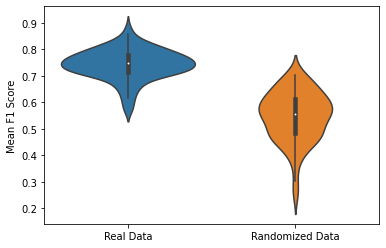

In [61]:
g = sns.violinplot(data=df_f1)
g.set_ylabel('Mean F1 Score')

In [63]:
from scipy.stats import ttest_rel
real_scores, random_scores = all_f1, shuffled_all_f1

# Calculate the p-value using a paired t-test
_, p_value = ttest_rel(real_scores, random_scores)

# Check if the p-value is below the significance level (e.g., 0.05)
significance_level = 0.05
if p_value < significance_level:
    print("The model's performance on real data is significantly better than random.")
else:
    print("There is no significant difference between the model's performance on real data and random.")

# Quantify the improvement using effect size measures (e.g., Cohen's d)
mean_real = np.mean(real_scores)
mean_random = np.mean(random_scores)
std_real = np.std(real_scores, ddof=1)
effect_size = (mean_real - mean_random) / std_real

print("Effect size (Cohen's d):", effect_size)

The model's performance on real data is significantly better than random.
Effect size (Cohen's d): 3.464010867870705


In [ ]:
df = best_raw_rable[['GT','predicted','correct','affiliative_level','filenames','dataset']].copy()

df['rat_number'] = df['filenames'].apply(extract_ratnum_from_file_name)
df['day_number'] = df['filenames'].apply(extract_daynum_from_file_name)

In [ ]:
# Percentage of time each rat was in the test or train datasets
rat_dataset_percentage = df.groupby('rat_number')['dataset'].value_counts(normalize=True) * 100
print("Percentage of time each rat was in the test or train datasets:")
print(rat_dataset_percentage)

# Percentage of time each rat was correctly predicted in the test dataset
test_correct_percentage = df[(df['dataset'] == 'test') & (df['correct'])].groupby('rat_number')['correct'].value_counts(normalize=True) * 100
print("\nPercentage of time each rat was correctly predicted in the test dataset:")
print(test_correct_percentage)

# Percentage of time each session was in the test or train datasets
session_dataset_percentage = df.groupby('filenames')['dataset'].value_counts(normalize=True) * 100
print("\nPercentage of time each session was in the test or train datasets:")
print(session_dataset_percentage)

# Percentage of times each session was correctly predicted in the test dataset
test_session_correct_percentage = df[(df['dataset'] == 'test') & (df['correct'])].groupby('filenames')['correct'].value_counts(normalize=True) * 100
print("\nPercentage of times each session was correctly predicted in the test dataset:")
print(test_session_correct_percentage)

In [ ]:
df

In [ ]:
import pandas as pd

# Assuming the dataframe is already loaded and named 'df'

total_count = len(df)  # Total count of samples in the dataset

# Percentage of time each session was in the test or train datasets
session_dataset_percentage = (df.groupby('filenames')['dataset'].value_counts() / total_count) * 100
print("\nPercentage of time each session was in the test or train datasets:")
print(session_dataset_percentage)

# Percentage of times each session was correctly predicted in the test dataset
test_session_correct_percentage = (df[(df['dataset'] == 'test') & (df['correct'])].groupby('filenames')['correct'].value_counts() / total_count) * 100
print("\nPercentage of times each session was correctly predicted in the test dataset:")
print(test_session_correct_percentage)


## Feature selection 

Feature selection steps:

1. Find top 2 candidates
2. Train model and get results
3. Add next candiate and repeat step 2.
4. If the resutls improved, add this featrue, if not, advance to the next candidate

Model trainig steps:

1. Split data

3. Impute missing values
    a. MissForest
    b. IterativeImputer
    
4. rescale data (or not)

5. Train model/s
    a. svm
    b. logistic regression
    c. random forest classifier
    d. knn classifier
    
6. Evaluate model/s


In [ ]:
imputer_class = MissForest
classifier_class = RandomForestClassifier

pipe = Pipeline([('imputer', imputer_class()), ('scaler', StandardScaler()),('classifier', classifier_class())])

In [ ]:
df_results_test

In [ ]:
df_results_test['dataset'] = 'test'
df_results_train['dataset'] = 'train'
df_results_all = pd.concat([df_results_train,df_results_test])
df_results_all['rat_num'] = df_results_all['files'].apply(extract_ratnum_from_file_name)
df_results_all['day_num'] = df_results_all['files'].apply(extract_day_from_file_name)

In [ ]:
sns.lmplot(data=df_results_all, x='day_num', y='affiliative_level', hue='GT', col='dataset')
sns.lmplot(data=df_results_all, x='day_num', y='affiliative_level', hue='predicted', col='dataset')


## Dimensionality reduction using t-SNE and visualization|

In [ ]:
# # create the figure and axes
# fig, ax = plt.subplots(figsize=(6, 6))

# # add the plots for each dataframe
# df_rats = df_results_all.groupby('rat_num')
# for ratnum , df_r in df_rats:
#     sns.regplot(x='day_num', y='affiliative_level', data=df_r, fit_reg=True, ci=None, ax=ax, label=ratnum)
# ax.set(ylabel='affiliative_level', xlabel='rat_num')
# ax.legend()
# plt.show()

In [ ]:
col_names = df_train.drop(['sociability','dataset'], axis = 1).columns

### Test data

In [ ]:
def plot_pairplot(title, X,y,y_pred):
    df_X = pd.DataFrame(X)


    df_X = df_X.rename(columns={num:cname for num, cname in enumerate(col_names)})
    df_X['GT'] = y
    df_X['predicted'] = y_pred
    df_X['correct'] = df_X['predicted'] == df_X['GT']

    g = sns.pairplot(data=df_X.drop(['predicted','correct'], axis=1), hue='GT')
    g.fig.suptitle(f"{title} Data GT sociability", y=1.05)

    g = sns.pairplot(data=df_X.drop(['GT','correct'], axis=1), hue='predicted')
    g.fig.suptitle(f"{title} Data GT predicted", y=1.05)
    

In [ ]:

X = X_test
y = y_test.values
y_pred = y_test_pred
title = 'Test - Unimputed'
plot_pairplot(title, X,y,y_pred)


X = X_train
y = y_train.values
y_pred = y_train_pred
title = 'Train - Unimputed'
plot_pairplot(title, X,y,y_pred)

X = X_test_imp
y = y_test.values
y_pred = y_test_pred
title = 'Test - Imputed'
plot_pairplot(title, X,y,y_pred)

X = X_train_imp
y = y_train.values
y_pred = y_train_pred
title = 'Train - Imputed'
plot_pairplot(title, X,y,y_pred)


In [ ]:
df_results_test

In [ ]:
df_results_test.columns

In [ ]:
X = X_test_imp

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df_results_test[['tsne1','tsne2']] = X_embedded
sns.pairplot(df_results_test[['GT','tsne1','tsne2']], hue='GT')
sns.pairplot(df_results_test[['predicted','tsne1','tsne2']], hue='predicted')


X = X_train_imp

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df_results_train[['tsne1','tsne2']] = X_embedded
sns.pairplot(df_results_train[['GT','tsne1','tsne2']], hue='GT')
sns.pairplot(df_results_train[['predicted','tsne1','tsne2']], hue='predicted')

In [ ]:


X = X_test_imp

X_embedded = TSNE(n_components=1, learning_rate='auto',
                  init='random', perplexity=2).fit_transform(X)

# df_results_test[['tsne1','tsne2']] = X_embedded
# sns.pairplot(df_results_test[['GT','tsne1','tsne2']], hue='GT')
# sns.pairplot(df_results_test[['predicted','tsne1','tsne2']], hue='predicted')

df_results_test[['tsne1']] = X_embedded
df_results_test['affiliative_level_logit'] = df_results_test['affiliative_level'].apply(logit)
sns.lmplot(data=df_results_test, x = 'affiliative_level_logit' ,y = 'tsne1', hue='GT')





# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
X = X_train_imp

X_embedded = TSNE(n_components=1, learning_rate='auto',
                  init='random', perplexity=1).fit_transform(X)

# df_results_test[['tsne1','tsne2']] = X_embedded
# sns.pairplot(df_results_test[['GT','tsne1','tsne2']], hue='GT')
# sns.pairplot(df_results_test[['predicted','tsne1','tsne2']], hue='predicted')

df_results_train[['tsne1']] = X_embedded
df_results_train['affiliative_level_logit'] = df_results_train['affiliative_level'].apply(logit)
sns.(data=df_results_train, x = 'affiliative_level_logit' ,y = 'tsne1', hue='GT')




# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
X = X_train_imp
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df_results_train[['tsne1','tsne2']] = X_embedded

sns.pairplot(df_results_train[['GT','tsne1','tsne2']], hue='GT')

sns.pairplot(df_results_train[['predicted','tsne1','tsne2']], hue='predicted')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# All data (train and test)


X = np.append(X_train_imp, X_test_imp, axis=0)
y = np.append(y_train, y_test)
y_pred = np.append(y_train_pred, y_test_pred)

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=10, n_iter=5000).fit_transform(X)


df_res_tsne = pd.DataFrame(y, columns=['GT'])
df_res_tsne['dataset'] = np.append(np.full(y_train.shape, "train"), np.full(y_test.shape, "test"))
df_res_tsne['predicted'] = y_pred
df_res_tsne['correct'] = df_res_tsne['predicted'] == df_res_tsne['GT']
df_res_tsne[['tsne1','tsne2']] = X_embedded
#Seaborn pair plot

sns.pairplot(df_res_tsne[['GT','tsne1','tsne2']], hue='GT')

sns.pairplot(df_res_tsne[['predicted','tsne1','tsne2']], hue='predicted')

# # Display the plots
# plt.tight_layout()
# plt.show()

In [ ]:
df_res_tsne.head(1)

### Impute the missing values of all the dataset before training and testing

Performing imputation before splitting the dataset can potentially lead to data leakage and overly optimistic evaluation results. It's generally recommended to split the dataset into training and testing sets before applying any data preprocessing steps, including imputation.

Data leakage can occur when information from the testing set is inadvertently used during the imputation process. This can lead to overfitting and unrealistic evaluation results because the imputation is informed by the target variable in the testing set.

In [ ]:
# imputer = IterativeImputer(max_iter=100)
imputer_class = MissForest

# model_class = RandomForestClassifier
# model = LogisticRegression(max_iter=10000)
# model_class = svm.SVC
model_class = tree.DecisionTreeClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[:,:3], y, test_size=0.33)

In [ ]:
# Impute data before splitting it into train and test

imputer = imputer_class()
model = model_class()

imputed_data = imputer.fit_transform(X_train)

# # Splitting the imputed data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(imputed_data,
#                                                     labels,
#                                                     test_size=0.3,
#                                                     stratify=labels)


# Creating and training the model (using Logistic Regression as an example)


model.fit(imputed_data, y_train)


# Making predictions on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Calculating accuracy scores
# train_accuracy = accuracy_score(y_train.values, y_train_pred)
# test_accuracy = accuracy_score(y_test.values, y_test_pred)
ret_test = eval_model(y_test, y_test_pred)
ret_train = eval_model(y_train, y_train_pred)



df_results_test = pd.DataFrame(y_test, columns={'GT'})
df_results_test['predicted'] = y_test_pred
df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
print(df_results_test)


print('Test')
[print(f'{metric}:{values}') for metric, values in ret_test.items()]
print('Train')
[print(f'{metric}:{values}') for metric, values in ret_train.items()]


### Imputing the data after each splitting

The imputaion quality drops when performing on smaller sub sets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score



# Splitting the imputed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.3,
                                                    stratify=labels)

imputer = imputer_class()
model = model_class()

imputed_data_train = imputer.fit_transform(X_train)
imputed_data_test = imputer.fit_transform(X_test)

# Converting the imputed data back to a DataFrame
imputed_data_train = pd.DataFrame(imputed_data_train, columns=X_train.columns)
imputed_data_test = pd.DataFrame(imputed_data_test, columns=X_test.columns)



# Creating and training the model (using Logistic Regression as an example)
# model = LogisticRegression()
model.fit(imputed_data_train, y_train)

# Making predictions on the training and testing sets
y_train_pred = model.predict(imputed_data_train)
y_test_pred = model.predict(imputed_data_test)

# Calculating accuracy scores
# train_accuracy = accuracy_score(y_train.values, y_train_pred)
# test_accuracy = accuracy_score(y_test.values, y_test_pred)
ret_test = eval_model(y_test, y_test_pred)
ret_train = eval_model(y_train, y_train_pred)


df_results_test = pd.DataFrame(y_test, columns={'GT'})
df_results_test['predicted'] = y_test_pred
df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
print(df_results_test)




print('Test')
[print(f'{metric}:{values}') for metric, values in ret_test.items()]
print('Train')
[print(f'{metric}:{values}') for metric, values in ret_train.items()]



### Cross validation
Since the data plitting have significant effect on the model performance, cross validation is important

In [ ]:
def one_fold(X_train, X_test, y_train, y_test):
        # Splitting the imputed data into training and testing sets


    imputer = imputer_class(max_iter=500)
    model = model_class()
    
    imputed_data_train = imputer.fit_transform(X_train)
    imputed_data_test = imputer.fit_transform(X_test)

    # Converting the imputed data back to a DataFrame
#     imputed_data_train = pd.DataFrame(imputed_data_train, columns=X_train.columns)
#     imputed_data_test = pd.DataFrame(imputed_data_test, columns=X_test.columns)
    
    # debug
#     print(imputed_data_test.shape)
#     print(imputed_data_test.shape)


    # Creating and training the model (using Logistic Regression as an example)
    
    model.fit(imputed_data_train, y_train)

    # Making predictions on the training and testing sets
    y_train_pred = model.predict(imputed_data_train)
    y_test_pred = model.predict(imputed_data_test)
    
    return y_train, y_train_pred, y_test, y_test_pred

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

# Define the cross-validation strategy
cv = KFold(n_splits=3, shuffle=True)
# cv = StratifiedKFold(n_splits=2, shuffle=True)

cv_scores_train = []
cv_scores_test = []
# for train_index, test_index in cv.split(data, rat_numbers):
for train_index, test_index in cv.split(data):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    y_train, y_train_pred, y_test, y_test_pred = one_fold(X_train, X_test, y_train, y_test)
    scores_train = eval_model(y_train, y_train_pred)
    scores_test = eval_model(y_test, y_test_pred)
    cv_scores_train.append(scores_train)
    cv_scores_test.append(scores_test)
# Summarize
ret_train = pd.DataFrame(cv_scores_train).mean()
ret_test = pd.DataFrame(cv_scores_test).mean()






In [ ]:
print('Test')
print(ret_test)

print('Train')
print(ret_train)

# print('Test')
# [[print(f'{metric}:{values}') for metric, values in ret.items()] for ret in cv_scores_test]
# print('Train')
# [[print(f'{metric}:{values}') for metric, values in ret.items()] for ret in cv_scores_train]


In [ ]:
 pd.DataFrame(cv_scores_test)

### Impute the data and see how it looks

In [ ]:
imputer = imputer_class(1000)
imputed_data = imputer.fit_transform(data)

In [ ]:
labels_num = np.array(labels=='affiliative', dtype=float)*0.1
labels_num = labels_num[:, np.newaxis]

In [ ]:

data_conc = np.concatenate((data.values, labels_num), axis=1)
plt.imshow(data_conc, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
imputed_data_concat = np.concatenate((imputed_data, labels_num), axis=1)
plt.imshow(imputed_data_concat, cmap='hot', interpolation='nearest')
plt.show()


In [ ]:
from sklearn.manifold import TSNE
X = imputed_data
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=15).fit_transform(X)
X_embedded.shape

In [ ]:
from sklearn.preprocessing import LabelEncoder

strings = filenames
label_encoder = LabelEncoder()
converted_numbers = label_encoder.fit_transform(strings)

strings = filenames
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(labels)

converted_numbers


rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]


In [ ]:
df_tsne = pd.DataFrame(X_embedded)

df_tsne['labels'] = labels
df_tsne['filenames'] = converted_numbers
df_tsne['rat_number'] = rat_numbers
# df_tsne['pred'] = 


In [ ]:
# get the dummies and store it in a variable
dummies = pd.get_dummies(df_tsne.labels)
 
# Concatenate the dummies to original dataframe
merged = pd.concat([df_tsne, dummies], axis='columns')
 
# drop the values
merged.drop(['labels'], axis='columns')

merged = merged[['rat_number','affiliative','aversive']].groupby('rat_number').sum()
merged['sum'] = merged['affiliative'] + merged['aversive']
merged

In [ ]:
sns.scatterplot(data=df_tsne, x=0, y=1, hue='labels')

In [ ]:
# sns.catplot(data=df_tsne, x=0, y=1, hue='rat_number', row='labels')

In [ ]:
# sns.catplot(data=df_tsne, x=0, y=1, hue='filenames', row='labels')

In [ ]:
G = nx.Graph()
all_pos = {}
colors = []
for r, df_r in df_tsne.groupby('rat_number'):


    f_names = df_r['filenames'].values
    pos_ = df_r[[0,1]].values
    pos_2 = {(r,f): p for p, f in zip(pos_,f_names)}
    mean_pos = np.mean(pos_,axis=0)
    pos_2[r] = mean_pos
    
    labels_sub = np.array(['b']* len(df_r))
    labels_sub[np.where(np.array(df_r['labels']=='affiliative'))] = 'g'
    
    all_pos.update(pos_2)
    [G.add_edge(r, (r,f)) for f in f_names]
    colors = np.append(colors, labels_sub)
# colors = np.array(colors).flatten()
fig = plt.figure(figsize=(40,80))
# nx.draw_networkx(G,all_pos)
nx.draw_networkx(G,all_pos, edge_color=colors, font_size=50,width=5)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# G = nx.Graph()
# all_pos = {}
# df_g = df_tsne.groupby('rat_number')
# n_groups = len(df_g)
# fig = plt.figure(figsize=(40,80))
# for n, (r, df_r) in enumerate(df_g):
#     G = nx.Graph()
#     plt.subplot(n_groups,1,n+1)

#     f_names = df_r['filenames'].values
#     pos_ = df_r[[0,1]].values
#     labels_sub = np.array(['b']* len(df_r))
#     labels_sub[np.where(np.array(df_r['labels']=='affiliative'))] = 'g'
# #     labels_sub = np.append(labels_sub, 'y', axis=None)
    
    
#     pos_2 = {(r,f): p for p, f in zip(pos_,f_names)}
#     mean_pos = np.mean(pos_,axis=0)
    
#     pos_2[r] = mean_pos
    
#     all_pos.update(pos_2)
#     [G.add_edge(r, (r,f)) for f in f_names]
    

#     nx.draw_networkx(G,pos_2, node_size=2000, font_size=50, edge_color=labels_sub)
#     ax = plt.gca()
#     ax.margins(0.08)
# #     plt.axis("off")
#     plt.tight_layout()
# plt.show()